In [49]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.metrics import classification_report, explained_variance_score
from sklearn.metrics import plot_confusion_matrix
import openpyxl

In [ ]:
dataset = pd.read_excel('./data/carddata3.xlsx', engine="openpyxl")

In [15]:
dataset.columns=["APPR_NO", "MCC_CODE", "MCC_NAME", "ACQ_CLASS", "APPR_DATE", "APPR_TIME", "MERCH_ADDR", "MERCH_NAME", "ABOARD", "APPR_AMT","TIPS","ACQU_FEE", "VAT", "ETC1", "ETC3", "CRD_FG_CD", "CRD_STL_DD", "EMP_NO", "EMP_DV_CD", "GRADE_CD", "TITLE_CD", "BP_CD", "BA_CD", "HKONT", "ACCT_NM"]
dataset = dataset.astype({'MCC_CODE': 'object', 'ETC3': 'object', 'TITLE_CD':'object', 'CRD_STL_DD':'object','BA_CD':'object' ,'HKONT': 'object'})
dataset = dataset.dropna(axis=0).reset_index()

for index, row in dataset.iterrows():
    if dataset["MERCH_ADDR"][index].isalpha():
        dataset["MERCH_ADDR"][index] = "Foreign"
    else:
        dataset["MERCH_ADDR"][index] = dataset["MERCH_ADDR"][index].split(" ")[1]

In [25]:
new_data = pd.DataFrame()
label_onehot = pd.DataFrame()
label_label = pd.DataFrame()
cate_col = ["MCC_CODE","MERCH_ADDR","ABOARD","ETC1","ETC3","CRD_FG_CD","CRD_STL_DD","TITLE_CD","BA_CD", "HKONT"]
day_week_array = []
day_range_array = []
time_range_array = []

# 금액 데이터 처리
appr_amt = np.array(dataset["APPR_AMT"]).reshape(-1, 1)
vat = np.array(dataset["VAT"]).reshape(-1, 1)
ss_amt=StandardScaler().fit_transform(appr_amt)
ss_vat=StandardScaler().fit_transform(vat)
reg_amt=MinMaxScaler().fit_transform(appr_amt)
reg_vat=MinMaxScaler().fit_transform(vat)
ss_amt_frame = pd.DataFrame(ss_amt, columns=['AMT'])
ss_vat_frame = pd.DataFrame(ss_vat, columns=['VAT'])
#reg_amt_frame = pd.DataFrame(reg_amt)
#reg_vat_frame = pd.DataFrame(reg_vat)

new_data = pd.concat([new_data, ss_amt_frame], axis=1)
new_data = pd.concat([new_data, ss_vat_frame], axis=1)
#new_data = pd.concat([new_data, reg_amt_frame], axis=1)
#new_data = pd.concat([new_data, reg_vat_frame], axis=1)
#new_data = pd.concat([new_data, dataset["APPR_AMT"]], axis=1)
#new_data = pd.concat([new_data, dataset["VAT"]], axis=1)

# 날짜 데이터 처리
datatemp = pd.DataFrame(dataset["APPR_DATE"])
for index, row in datatemp.iterrows():
    temp_year  = int(str(dataset["APPR_DATE"][index])[0:4])
    temp_month = int(str(dataset["APPR_DATE"][index])[4:6])
    temp_day   = int(str(dataset["APPR_DATE"][index])[6:8])
    day = date(temp_year, temp_month, temp_day).weekday()

    if temp_day < 10:
        range_day = 0
    elif temp_day >= 10 and temp_day < 20:
        range_day = 1
    else:
        range_day = 2    
        
    day_week_array.append(day)
    day_range_array.append(range_day)

new_data = pd.concat([new_data, pd.DataFrame(day_week_array, columns=['WEEK'])], axis=1)
new_data = pd.concat([new_data, pd.DataFrame(day_range_array, columns=['RANGE_DAY'])], axis=1)

# 시간 데이터 처리
datatemp = pd.DataFrame(dataset["APPR_TIME"])
for index, row in datatemp.iterrows():
    temp_time   = int(str(dataset["APPR_TIME"][index])[0:2])

    if temp_time <10:
        range_time = 0
    if temp_time >= 10 and temp_time < 12:
        range_time = 1
    elif temp_time >= 12 and temp_time < 14:
        range_time = 2
    elif temp_time >= 14 and temp_time < 16:
        range_time = 3
    elif temp_time >= 16 and temp_time < 18:
        range_time = 4
    elif temp_time >= 18 and temp_time < 20:
        range_time = 5
    else:
        range_time = 6

    time_range_array.append(range_time)    
    
new_data = pd.concat([new_data, pd.DataFrame(time_range_array, columns=['RANGE_TIME'])], axis=1)

# categorical data 처리
label_data = pd.DataFrame()
for col in dataset.columns:
    if col in cate_col:
        le = LabelEncoder()
        le.fit(dataset[col])
        temp = pd.DataFrame(le.transform(dataset[col]), columns=[col])
        label_data = pd.concat([label_data, temp], axis = 1)

train = pd.concat([new_data, label_data.iloc[:,:-1]], axis=1)
train

,AMT,VAT,WEEK,RANGE_DAY,RANGE_TIME,MCC_CODE,MERCH_ADDR,ABOARD,ETC1,ETC3,CRD_FG_CD,CRD_STL_DD,TITLE_CD,BA_CD
0,0.223239,0.246525,4,2,6,127,44,0,3,0,1,0,2,6
1,2.472689,2.577533,6,0,1,12,118,0,3,0,1,0,2,6
2,0.257886,0.282356,4,2,6,127,44,0,3,0,1,0,2,6
3,-0.086370,-0.074173,0,1,2,124,60,0,3,0,1,0,2,6
4,0.307655,0.334226,3,1,2,1,60,0,2,0,1,1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36498,-0.283399,-0.278199,2,2,4,48,7,0,1,0,0,4,4,0
36499,-0.295521,-0.290785,1,2,2,48,7,0,1,0,0,4,4,0
36500,-0.292492,-0.287626,0,2,1,48,7,0,1,0,0,4,4,0
36501,-0.295521,-0.290785,0,2,1,48,7,0,1,0,0,4,4,0


In [26]:
test = label_data.iloc[:,-1:]
test

,HKONT
0,2
1,2
2,2
3,1
4,2
...,...
36498,9
36499,9
36500,9
36501,9


In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.25, random_state=123456)

In [31]:
# basic

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.663
Mean accuracy score: 0.667


<AxesSubplot:>

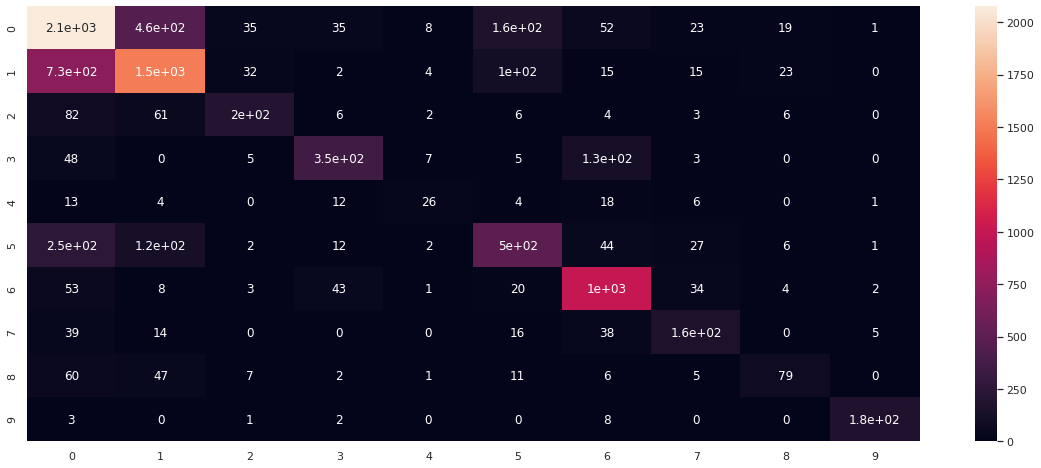

In [35]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [37]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      2874
           1       0.68      0.62      0.65      2429
           2       0.70      0.54      0.61       367
           3       0.76      0.64      0.69       551
           4       0.51      0.31      0.39        84
           5       0.61      0.52      0.56       966
           6       0.76      0.86      0.81      1177
           7       0.58      0.59      0.58       271
           8       0.58      0.36      0.45       218
           9       0.95      0.93      0.94       189

    accuracy                           0.67      9126
   macro avg       0.67      0.61      0.63      9126
weighted avg       0.67      0.67      0.66      9126



In [40]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [41]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

In [46]:
rf = RandomForestClassifier(n_estimators = 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap= False, random_state=123456)
rf.fit(X_train, y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.679


<AxesSubplot:>

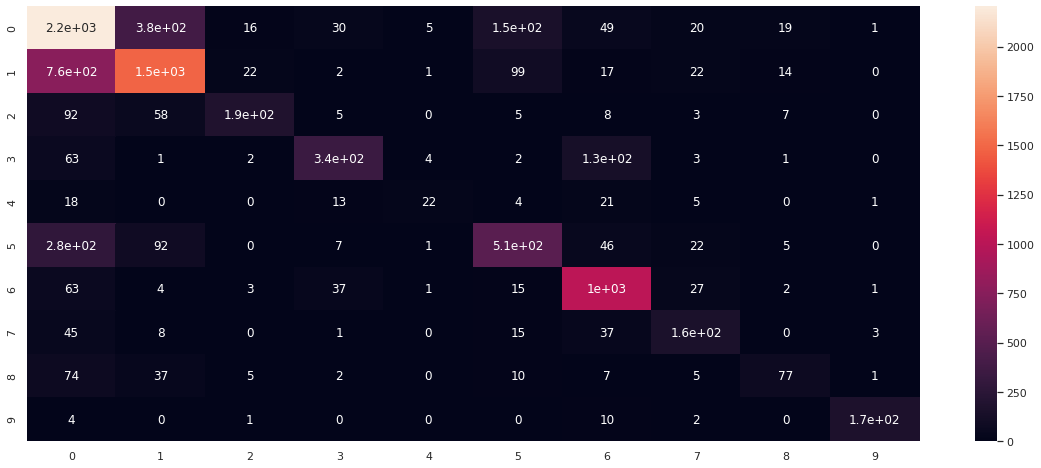

In [48]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [47]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.61      0.77      0.68      2874
           1       0.72      0.61      0.66      2429
           2       0.79      0.51      0.62       367
           3       0.78      0.62      0.69       551
           4       0.65      0.26      0.37        84
           5       0.63      0.53      0.58       966
           6       0.76      0.87      0.81      1177
           7       0.60      0.60      0.60       271
           8       0.62      0.35      0.45       218
           9       0.96      0.91      0.93       189

    accuracy                           0.68      9126
   macro avg       0.71      0.60      0.64      9126
weighted avg       0.69      0.68      0.67      9126



In [50]:
perm = PermutationImportance(rf, random_state=203).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1871 ± 0.0044,MCC_CODE
0.1681 ± 0.0081,TITLE_CD
0.1164 ± 0.0065,BA_CD
0.0602 ± 0.0056,MERCH_ADDR
0.0278 ± 0.0009,AMT
0.0219 ± 0.0021,CRD_FG_CD
0.0218 ± 0.0031,VAT
0.0203 ± 0.0029,ETC1
0.0193 ± 0.0025,RANGE_TIME
0.0139 ± 0.0020,CRD_STL_DD


In [54]:
# basic

xgb = XGBClassifier(learning_rate=0.02, objective='multi:softprob').fit(X_train, y_train)
predicted_xgb = xgb.predict(X_test)
print('train acc : ', accuracy_score(y_train, xgb.predict(X_train)))
print('test acc : ', accuracy_score(y_test, predicted_xgb))

train acc :  0.5717207875223728
test acc :  0.5656366425597195


<AxesSubplot:>

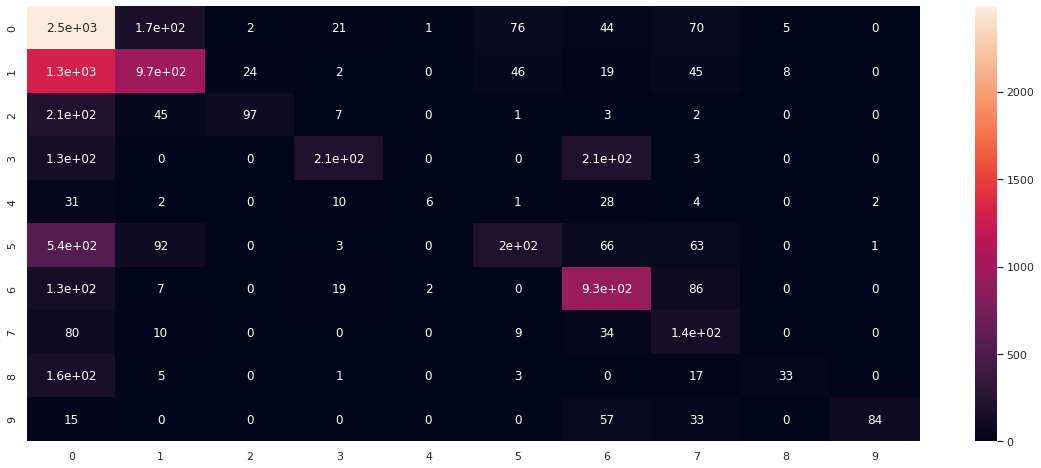

In [55]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted_xgb))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [56]:
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.49      0.87      0.62      2874
           1       0.75      0.40      0.52      2429
           2       0.79      0.26      0.40       367
           3       0.77      0.38      0.51       551
           4       0.67      0.07      0.13        84
           5       0.59      0.21      0.31       966
           6       0.67      0.79      0.73      1177
           7       0.30      0.51      0.38       271
           8       0.72      0.15      0.25       218
           9       0.97      0.44      0.61       189

    accuracy                           0.57      9126
   macro avg       0.67      0.41      0.44      9126
weighted avg       0.63      0.57      0.54      9126



In [63]:
min_child_weight =[1, 5, 10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.6, 0.8, 1.0]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [3, 4, 5]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = { 'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'min_child_weight' : min_child_weight,
                'gamma' : gamma,
                'subsample' :subsample,
                'colsample_bytree' : colsample_bytree}
pprint(random_grid)

{'bootstrap': [True, False],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'max_depth': [3, 4, 5],
 'max_features': ['auto', 'sqrt'],
 'min_child_weight': [1, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'subsample': [0.6, 0.8, 1.0]}


In [64]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax', silent=True, nthread=1)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(learning_rate=0.02, n_estimators=600,
                                           nthread=1, objective='multi:softmax',
                                           silent=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_child_weight': [1, 5, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200,

In [65]:
xgb_random.best_params_ 

{'subsample': 0.8,
 'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'min_child_weight': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 1.0,
 'bootstrap': True}

In [66]:
# tuning

xgb = XGBClassifier(learning_rate=0.02, objective='multi:softprob',subsample = 0.8,
n_estimators = 1800,
min_samples_split = 2,
min_samples_leaf = 4,
min_child_weight = 1,
max_features = 'sqrt',
max_depth = 5,
gamma = 2,
colsample_bytree = 1.0,
bootstrap = True).fit(X_train, y_train)
predicted_xgb = xgb.predict(X_test)
print('train acc : ', accuracy_score(y_train, xgb.predict(X_train)))
print('test acc : ', accuracy_score(y_test, predicted_xgb))

train acc :  0.7413157029623406
test acc :  0.6767477536708306


<AxesSubplot:>

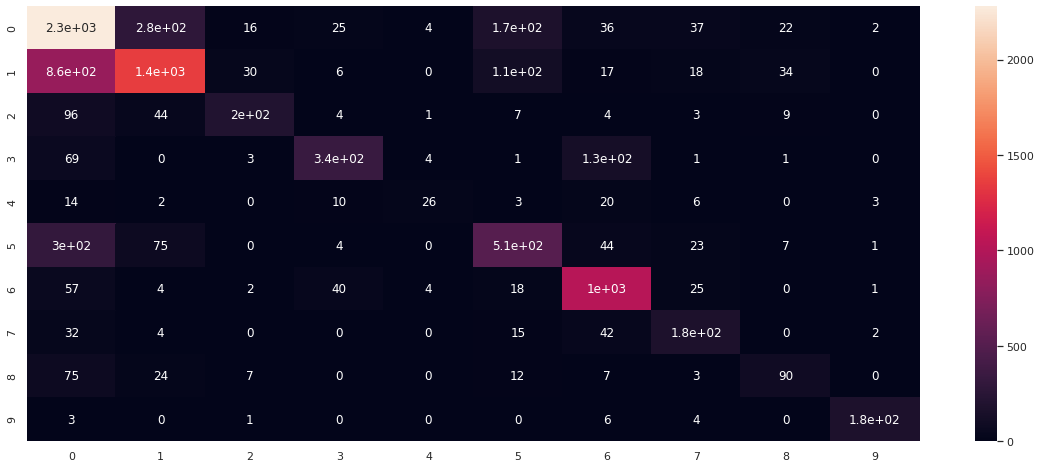

In [67]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted_xgb))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [70]:
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.60      0.79      0.68      2874
           1       0.76      0.56      0.64      2429
           2       0.77      0.54      0.64       367
           3       0.79      0.62      0.70       551
           4       0.67      0.31      0.42        84
           5       0.60      0.53      0.56       966
           6       0.77      0.87      0.82      1177
           7       0.59      0.65      0.62       271
           8       0.55      0.41      0.47       218
           9       0.95      0.93      0.94       189

    accuracy                           0.68      9126
   macro avg       0.71      0.62      0.65      9126
weighted avg       0.69      0.68      0.67      9126



In [71]:
perm = PermutationImportance(xgb, random_state=203).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2046 ± 0.0073,MCC_CODE
0.1681 ± 0.0063,TITLE_CD
0.1147 ± 0.0068,BA_CD
0.0743 ± 0.0031,AMT
0.0696 ± 0.0039,MERCH_ADDR
0.0272 ± 0.0041,VAT
0.0211 ± 0.0043,ETC1
0.0146 ± 0.0052,RANGE_TIME
0.0122 ± 0.0010,CRD_STL_DD
0.0120 ± 0.0024,CRD_FG_CD


In [73]:
#under sample
X_under, y_under = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
# over sample
X_samp_smote, y_samp_smote = SMOTE(random_state=4).fit_resample(X_train, y_train)

In [74]:
# under

rf = RandomForestClassifier(n_estimators = 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap= False, random_state=123456)
rf.fit(X_under, y_under)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

<AxesSubplot:>

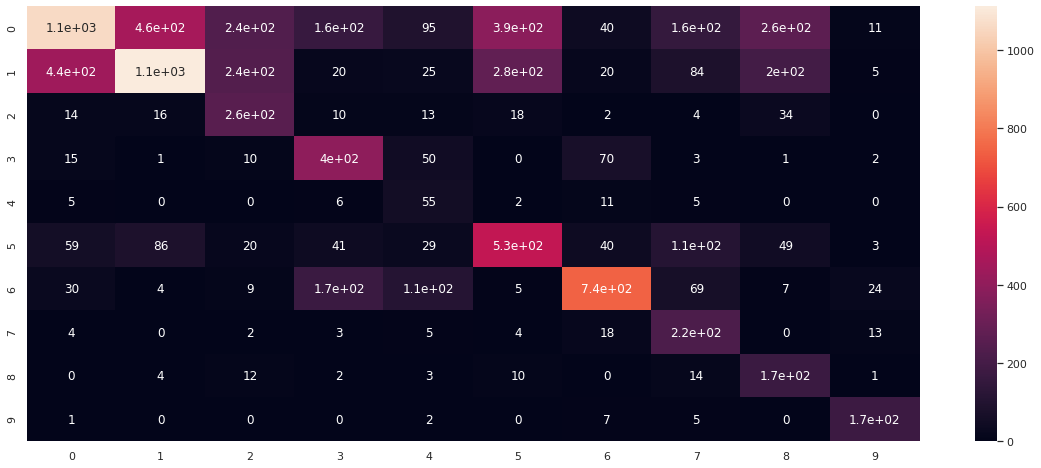

In [75]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [76]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      0.37      0.47      2874
           1       0.66      0.46      0.54      2429
           2       0.32      0.70      0.44       367
           3       0.49      0.72      0.58       551
           4       0.14      0.65      0.23        84
           5       0.43      0.55      0.48       966
           6       0.78      0.63      0.70      1177
           7       0.33      0.82      0.47       271
           8       0.24      0.79      0.36       218
           9       0.75      0.92      0.82       189

    accuracy                           0.52      9126
   macro avg       0.48      0.66      0.51      9126
weighted avg       0.60      0.52      0.53      9126



In [77]:
# over

rf = RandomForestClassifier(n_estimators = 1800,
 min_samples_split = 10,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 110,
 bootstrap= False, random_state=123456)
rf.fit(X_samp_smote, y_samp_smote)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

<AxesSubplot:>

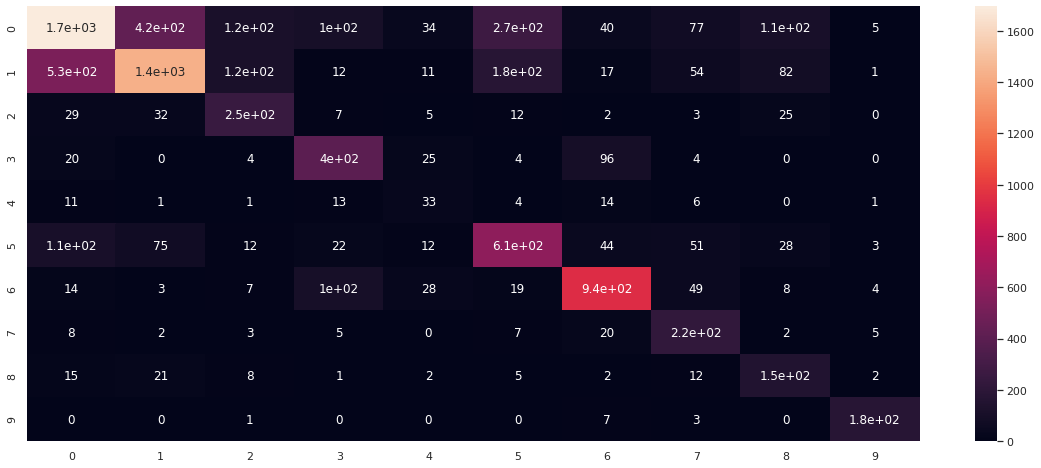

In [78]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [79]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      2874
           1       0.72      0.59      0.65      2429
           2       0.48      0.69      0.57       367
           3       0.60      0.72      0.66       551
           4       0.22      0.39      0.28        84
           5       0.55      0.63      0.59       966
           6       0.80      0.80      0.80      1177
           7       0.46      0.81      0.58       271
           8       0.37      0.69      0.48       218
           9       0.89      0.94      0.92       189

    accuracy                           0.65      9126
   macro avg       0.58      0.69      0.62      9126
weighted avg       0.67      0.65      0.65      9126



In [80]:
# under

xgb = XGBClassifier(learning_rate=0.02, objective='multi:softprob',subsample = 0.8,
n_estimators = 1800,
min_samples_split = 2,
min_samples_leaf = 4,
min_child_weight = 1,
max_features = 'sqrt',
max_depth = 5,
gamma = 2,
colsample_bytree = 1.0,
bootstrap = True).fit(X_under, y_under)
predicted_xgb = xgb.predict(X_test)

<AxesSubplot:>

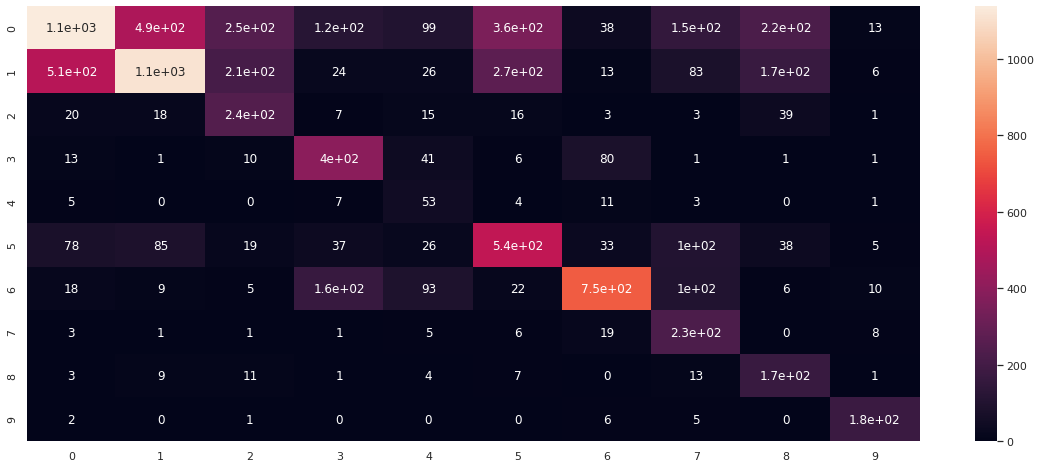

In [81]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted_xgb))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [82]:
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.64      0.40      0.49      2874
           1       0.65      0.46      0.54      2429
           2       0.32      0.67      0.44       367
           3       0.53      0.72      0.61       551
           4       0.15      0.63      0.24        84
           5       0.44      0.56      0.49       966
           6       0.79      0.64      0.70      1177
           7       0.33      0.84      0.47       271
           8       0.26      0.78      0.39       218
           9       0.79      0.93      0.85       189

    accuracy                           0.53      9126
   macro avg       0.49      0.66      0.52      9126
weighted avg       0.60      0.53      0.54      9126



In [83]:
# over

xgb = XGBClassifier(learning_rate=0.02, objective='multi:softprob',subsample = 0.8,
n_estimators = 1800,
min_samples_split = 2,
min_samples_leaf = 4,
min_child_weight = 1,
max_features = 'sqrt',
max_depth = 5,
gamma = 2,
colsample_bytree = 1.0,
bootstrap = True).fit(X_samp_smote, y_samp_smote)
predicted_xgb = xgb.predict(X_test)

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted_xgb))
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, predicted_xgb))